# Python Technical Challenge

## _Searching an algorithm that sorts words from left to right line by line_

c: Dominic Catana <catanadominic@gmail.com>

[133.87486267089844, 511.69140625]
[176.7246856689453, 510.94622802734375]
[176.8830108642578, 520.0508422851562]
[134.03318786621094, 520.7960205078125]
[110.84564971923828, 510.99517822265625]
[130.67434692382812, 510.99517822265625]
[130.67434692382812, 521.0720825195312]
[110.84564971923828, 521.0720825195312]
[89.71671295166016, 510.99517822265625]
[108.8952865600586, 510.99517822265625]
[108.8952865600586, 521.0720825195312]
[89.71671295166016, 521.0720825195312]
[191.95838928222656, 510.49652099609375]
[217.75697326660156, 509.2276916503906]
[218.26809692382812, 519.6204833984375]
[192.46951293945312, 520.8893432617188]
[179.46607767535104, 510.31321618621934]
[190.51786555238917, 510.39050278452044]
[190.44285208933223, 521.1172380769398]
[179.3910642122941, 521.0399514786387]
[221.04116821289062, 509.0448303222656]
[244.44552612304688, 509.0448303222656]
[244.44552612304688, 518.796630859375]
[221.04116821289062, 518.796630859375]
[247.25387573242188, 508.1828308105469]
[268.1

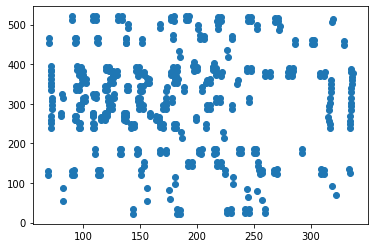

In [66]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


f = open('datasets/menu2.json',)
data = json.load(f)['ocr'];
#print(data);

img = cv2.imread('datasets/menu2.jpg')  # read RGB image 

list_of_coords = []
c = 0
for it in data:
    for y in it['points']:
        list_of_coords.append(y)
       # print(y)
    
color = (255, 0, 0)

start_point = (0, 0)
end_point = (0, 0)
j = 0
for i in list_of_coords:
   # print(i)
    if (j % 2 == 1) and (start_point == (0,0)):
        start_point = (int(i[0]),int(i[1]))
        j=j+1
    elif (j % 2 == 1) and (end_point == (0,0)): 
        end_point=(int(i[0]),int(i[1]))
        j=j+1
    else:
        j=j+1
        continue;
    
    if (start_point!=(0, 0) and (end_point!=(0, 0))):
        image = cv2.rectangle(img, start_point, end_point, color, 1)
        start_point = (0,0)
        end_point = (0,0)
        
data = np.array([
    list_of_coords
])
x, y = data.T

plt.scatter(x,y)
plt.show()





cv2.imshow('image', img)  #show the image
cv2.waitKey(0)  # Maintain output window untill user presses a key        
cv2.destroyAllWindows()









